In [1]:
"""
This script is an example of analyzing the data
collected from the run_readout_scan. Data collection
example can be found in recirq/readout_scan/tasks.py
"""
import cirq
import recirq

from recirq.readout_scan.tasks import EXPERIMENT_NAME, DEFAULT_BASE_DIR

In [2]:
# load data and use pandas
import numpy as np
import pandas as pd

records = []
# Load all data, do some light processing
for record in recirq.iterload_records(dataset_id='2020-02-tutorial', base_dir=DEFAULT_BASE_DIR):
    # Expand task dataclass into columns
    recirq.flatten_dataclass_into_record(record, 'task')

    # Unwrap BitArray into np.ndarray
    all_bitstrings = [ba.bits for ba in record['all_bitstrings']]

    # Compute <Z>
    record['z_vals'] = [np.mean((-1)**bitstrings, axis=0).item() for bitstrings in all_bitstrings]

    # Don't need to carry around the full array of bits anymore
    del record['all_bitstrings']
    records.append(record)

df = pd.DataFrame(records)
print(len(df))
df.head()

5


,timestamp,thetas,dataset_id,device_name,n_shots,qubit,resolution_factor,z_vals
0,2021-11-14T15:05:07.936362,"[-1.5707963267948966, -1.3089969389957472, -1....",2020-02-tutorial,Syc23-simulator,40000,"(3, 2)",6,"[-0.0057, 0.2563, 0.4915, 0.69605, 0.85955, 0...."
1,2021-11-14T15:05:10.481004,"[-1.5707963267948966, -1.3089969389957472, -1....",2020-02-tutorial,Syc23-simulator,40000,"(4, 1)",6,"[-0.00585, 0.2594, 0.50185, 0.70555, 0.8625, 0..."
2,2021-11-14T15:05:18.005737,"[-1.5707963267948966, -1.3089969389957472, -1....",2020-02-tutorial,Syc23-simulator,40000,"(5, 0)",6,"[0.00395, 0.2566, 0.497, 0.6986, 0.85825, 0.95..."
3,2021-11-14T15:05:13.020797,"[-1.5707963267948966, -1.3089969389957472, -1....",2020-02-tutorial,Syc23-simulator,40000,"(4, 2)",6,"[-0.0008, 0.2607, 0.50125, 0.7043, 0.85865, 0...."
4,2021-11-14T15:05:15.541112,"[-1.5707963267948966, -1.3089969389957472, -1....",2020-02-tutorial,Syc23-simulator,40000,"(4, 3)",6,"[0.0001, 0.2597, 0.5062, 0.7056, 0.8595, 0.960..."


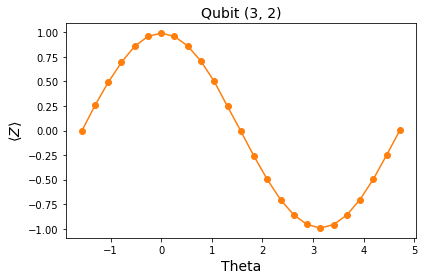

In [3]:
# plot data
%matplotlib inline
from matplotlib import pyplot as plt

entry = df.iloc[0] # Pick the first qubit

plt.plot([], []) # advance color cycle in anticipation of future analysis
plt.plot(entry['thetas'], entry['z_vals'], 'o-')
plt.xlabel('Theta', fontsize=14)
plt.ylabel(r'$\langle Z \rangle$', fontsize=14)
plt.title("Qubit {}".format(entry['qubit']), fontsize=14)
plt.tight_layout()

In [4]:
# compare to analytical results
qubit = cirq.LineQubit(0)
thetas = df.iloc[0]['thetas']

class _DummyMeasurementGate(cirq.IdentityGate):
    """A dummy measurement used to trick simulators into applying
    readout error when using PauliString.expectation_from_xxx."""

    def _measurement_key_(self):
        return 'dummy!'

    def __repr__(self):
        if self.num_qubits() == 1:
            return '_DummyMeasurementGate'
        return '_DummyMeasurementGate({!r})'.format(self.num_qubits())

    def __str__(self):
        if (self.num_qubits() == 1):
            return 'dummyM'
        else:
            return 'dummyM({})'.format(self.num_qubits())

    def _circuit_diagram_info_(self, args):
        from cirq import protocols
        return protocols.CircuitDiagramInfo(
            wire_symbols=('dM',) * self.num_qubits(), connected=True)

def dummy_measure(qubits):
    return _DummyMeasurementGate(num_qubits=len(qubits)).on(*qubits)

def get_circuit(theta):
    return cirq.Circuit([
        cirq.ry(theta).on(qubit),
        dummy_measure([qubit])
    ])

true_z_vals = []
for theta in thetas:
    wf = cirq.final_state_vector(get_circuit(theta))
    op = cirq.Z(qubit) * 1.
    true_z_val = op.expectation_from_state_vector(wf, qubit_map={qubit:0}, check_preconditions=False)
    true_z_vals.append(np.real_if_close(true_z_val).item())

true_z_vals = np.array(true_z_vals)
true_z_vals

array([ 0.        ,  0.25881901,  0.5       ,  0.70710677,  0.86602539,
        0.96592587,  1.        ,  0.96592587,  0.86602539,  0.70710677,
        0.5       ,  0.25881901,  0.        , -0.25881901, -0.5       ,
       -0.70710677, -0.86602539, -0.96592587, -1.        , -0.96592587,
       -0.86602539, -0.70710677, -0.5       , -0.25881901,  0.        ])

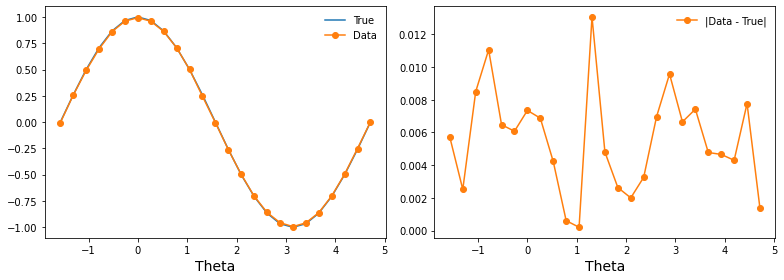

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.plot(thetas, true_z_vals, '-', label='True')
ax1.plot(entry['thetas'], entry['z_vals'], 'o-', label='Data')

ax2.plot([], []) # advance color cycle
ax2.plot(entry['thetas'], np.abs(true_z_vals - entry['z_vals']), 'o-', label='|Data - True|')

ax1.legend(loc='best', frameon=False)
ax2.legend(loc='best', frameon=False)
ax1.set_xlabel('Theta', fontsize=14)
ax2.set_xlabel('Theta', fontsize=14)

fig.tight_layout()

In [6]:
# learn you model
import scipy.optimize
import cirq.contrib.noise_models as ccn

def get_obj_func(data_expectations):
    all_results = []
    def obj_func(x):
        depol_prob, decay_prob, readout_prob = x

        if depol_prob < 0 or decay_prob < 0 or readout_prob < 0:
            # emulate constraints by returning a high cost if we
            # stray into invalid territory
            return 1000

        sim = cirq.DensityMatrixSimulator(
            noise=ccn.DepolarizingWithDampedReadoutNoiseModel(
                depol_prob=depol_prob, decay_prob=decay_prob, bitflip_prob=readout_prob))

        results = []
        for theta in thetas:            
            density_result = sim.simulate(get_circuit(theta))
            op = cirq.Z(qubit) * 1.
            true_z_val = op.expectation_from_state_vector(
                density_result.final_density_matrix, 
                qubit_map=density_result.qubit_map, check_preconditions=False)
            results.append(np.real_if_close(true_z_val).item())

        results = np.array(results)
        all_results.append(results)
        cost = np.sum(np.abs(results - data_expectations))
        return cost

    return obj_func, all_results

In [7]:
def print_result(x):
        depol_prob, decay_prob, readout_prob = x
        print(f'depol   = {depol_prob:.2%}')
        print(f'decay   = {decay_prob:.2%}')
        print(f'readout = {readout_prob:.2%}')

In [8]:
dfb = df
dfb = dfb.head(5) # Remove this to do all qubits
len(dfb)

5

Optimization terminated successfully.
         Current function value: 0.190792
         Iterations: 69
         Function evaluations: 135
Qubit 3, 2
depol   = 1.37%
decay   = 0.00%
readout = 0.00%


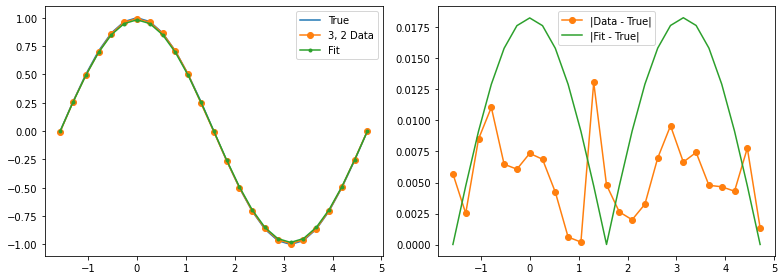

Optimization terminated successfully.
         Current function value: 0.215724
         Iterations: 66
         Function evaluations: 128
Qubit 4, 1
depol   = 1.37%
decay   = 0.00%
readout = 0.00%


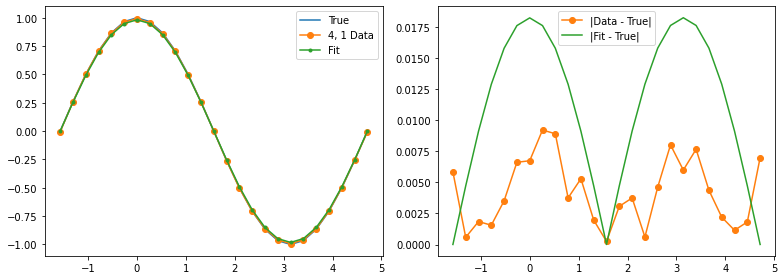

Optimization terminated successfully.
         Current function value: 0.176159
         Iterations: 69
         Function evaluations: 135
Qubit 5, 0
depol   = 1.37%
decay   = 0.00%
readout = 0.00%


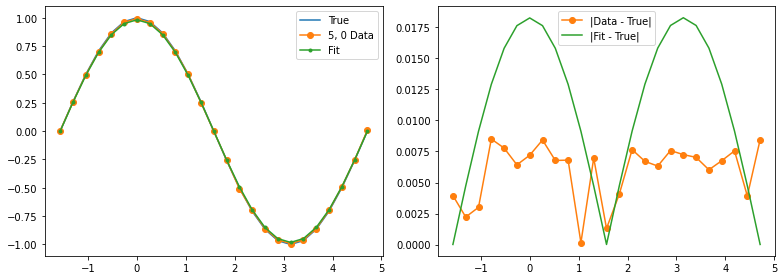

Optimization terminated successfully.
         Current function value: 0.209458
         Iterations: 66
         Function evaluations: 128
Qubit 4, 2
depol   = 1.37%
decay   = 0.00%
readout = 0.00%


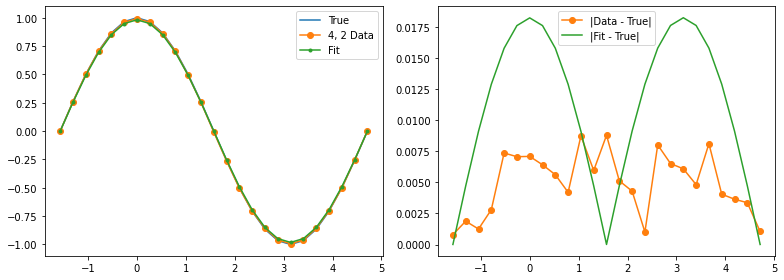

Optimization terminated successfully.
         Current function value: 0.050129
         Iterations: 147
         Function evaluations: 256
Qubit 4, 3
depol   = 0.00%
decay   = 0.10%
readout = 0.27%


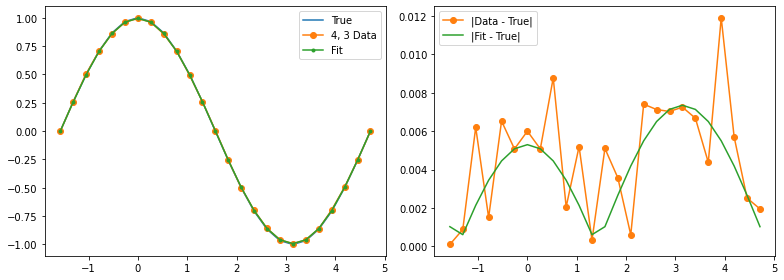

In [9]:
# Initial values
depol_prob = 0.01
decay_prob = 0.01
readout_prob = 0.01

opt_results = []
for i, entry in dfb.iterrows():
    ofunc, results = get_obj_func(entry['z_vals'])    
    opt_result = scipy.optimize.minimize(ofunc, 
                                         [depol_prob, decay_prob, readout_prob],
                                         method='nelder-mead',
                                         options={'disp': True})
    label = f"{entry['qubit'].row}, {entry['qubit'].col}"
    print("Qubit", label)
    print_result(opt_result.x)
    opt_results.append(opt_result)

    data_expectations = entry['z_vals']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    ax1.plot(thetas, true_z_vals, label='True')
    ax1.plot(thetas, data_expectations, 'o-', label=f'{label} Data')
    ax1.plot(thetas, results[-1], '.-', label='Fit')

    ax2.plot([], []) # advance color cycle
    ax2.plot(thetas, np.abs(true_z_vals - data_expectations), 'o-', label='|Data - True|')
    ax2.plot(thetas, np.abs(true_z_vals - results[-1]), '-', label='|Fit - True|')
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    fig.tight_layout()
    plt.show()